# Dropout Concepts

In [84]:
import torch
import torch.nn as nn
import torch.nn.functional as F

## Using dropout from nn package

In [53]:
p = 0.5
dropout = nn.Dropout(p) # instance of the Dropout Class
trial = torch.ones(10) # trial data
y = dropout(trial)
print(trial)

# Notice that the probability of each sample being dropped out is 'p', but not that 'p' of the neurons must be dropped out
print(y)

# will be around 1 most of the time (but not necessarly 1 as it's not necessary that 'p' of the neruons are dropped out)
print(torch.mean(y))

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([0., 2., 0., 0., 2., 2., 2., 2., 2., 0.])
tensor(1.2000)


In [54]:
dropout.eval()
y = dropout(trial)
print(y) # no dropout as we are in eval mode
print(torch.mean(y))

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor(1.)


In [55]:
# the model needs to be reset after toggling into eval mode

dropout.train()
y = dropout(trial)
print(y) # with dropout


dropout.eval()
y = dropout(trial) # without dropout
print(y)

tensor([0., 2., 0., 2., 0., 2., 2., 0., 0., 2.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])


## Using dropout from F package

In [56]:
y = F.dropout(trial)
print(y)

# will be around 1 most of the time (but not necessarly 1 as it's not necessary that 'p' of the neruons are dropped out)
print(torch.mean(y))

tensor([0., 0., 0., 2., 0., 2., 2., 0., 0., 2.])
tensor(0.8000)


In [57]:
dropout.eval() # won't work as it's not related to the F package
y = F.dropout(trial)
print(y)
print(torch.mean(y))

tensor([0., 2., 0., 0., 2., 0., 2., 2., 2., 0.])
tensor(1.)


In [58]:
y = F.dropout(trial, training=False) # will disable dropout, will see how to use it practically in the next example
print(y)
print(torch.mean(y))

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor(1.)


# Importing Iris Dataset for Practical Examples

In [85]:
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader, TensorDataset

In [86]:
iris = sns.load_dataset('iris')
data_iris = torch.tensor( iris[iris.columns[0:4]].values ).float()

# transform species to number
labels_iris = torch.zeros(len(data_iris), dtype=torch.long)
labels_iris[iris.species=='versicolor'] = 1
labels_iris[iris.species=='virginica'] = 2

In [87]:
train_data, test_data, train_labels, test_labels = train_test_split(data_iris, labels_iris, test_size=0.2)

train_data = TensorDataset(train_data, train_labels)
test_data = TensorDataset(test_data, test_labels)

batch = 16
train_loader = DataLoader(train_data, batch_size=batch, shuffle=True)
test_loader = DataLoader(test_data, batch_size=test_data.tensors[0].shape[0])

# Dropout Practical Example with Iris Dataset

## Define Model

In [62]:
class Iris_Dropout_Model(nn.Module):
  def __init__(self, dropout_rate):
    super().__init__()

    self.input = nn.Linear(4, 32)
    self.hidden = nn.Linear(32, 32)
    self.out = nn.Linear(32, 3)

    self.drop = dropout_rate

  def forward(self, x):
    x = F.relu(self.input(x))
    x = F.dropout(x, p=self.drop, training=self.training)   # when switching moel mode to eval, dropout will be turned off

    x = F.relu(self.hidden(x))
    x = F.dropout(x, p=self.drop, training=self.training)

    x = self.out(x)
    return x


### Test the model Once

In [63]:
tmp_model = Iris_Dropout_Model(0.25)

# run some random data through
tmp_data = torch.randn((10,4))
y_hat = tmp_model(tmp_data)
y_hat

tensor([[ 0.0044, -0.1702,  0.0558],
        [-0.0723, -0.1727,  0.0137],
        [-0.0448, -0.0018, -0.0861],
        [ 0.0773, -0.0675,  0.1583],
        [ 0.0914, -0.3355, -0.0258],
        [ 0.0552, -0.2122,  0.0891],
        [ 0.0119, -0.1504,  0.0959],
        [ 0.0346, -0.2051, -0.0178],
        [ 0.0045, -0.1039,  0.0504],
        [ 0.0040, -0.2044,  0.0397]], grad_fn=<AddmmBackward0>)

### Creating and training Functions

In [88]:
def create_drop_iris(dropout, learning_rate):
  iris_model = Iris_Dropout_Model(dropout_rate=dropout)

  loss_fun = nn.CrossEntropyLoss()

  optimizer = torch.optim.SGD(iris_model.parameters(), lr=learning_rate)

  return iris_model, loss_fun, optimizer

In [89]:
def train_drop_iris(model, loss_fun, optimizer, epochs):
  train_acc = []
  test_acc = []

  for e in range(epochs):
    model.train()

    batch_acc = []
    for x,y in train_loader:
      y_hat = model(x)
      loss = loss_fun(y_hat, y)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      batch_acc.append(100* torch.mean((torch.argmax(y_hat, axis=1) == y).float()).item())

    train_acc.append(np.mean(batch_acc))

    # testing
    model.eval()
    x, y = next(iter(test_loader))
    pred = model(x)
    test_acc.append(100 * torch.mean((torch.argmax(pred, axis=1) == y).float()).item())

  return train_acc, test_acc

## Parametric Experiment on Different Dropout rated

In [69]:
dropout_rates = np.arange(10)/10
results = np.zeros((len(dropout_rates),2))

for i in range(len(dropout_rates)):

  # create and train the model
  iris_model,lossfun,optimizer = create_drop_iris(dropout=dropout_rates[i], learning_rate=0.002)
  train_acc,test_acc = train_drop_iris(model=iris_model, loss_fun=lossfun, optimizer=optimizer, epochs=500)

  # store accuracies
  results[i,0] = np.mean(train_acc[-50:])
  results[i,1] = np.mean(test_acc[-50:])

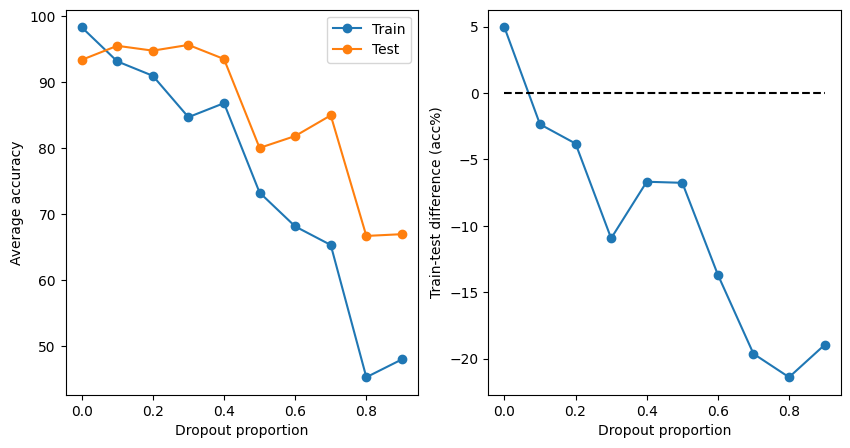

In [70]:
# plot the experiment results
fig,ax = plt.subplots(1,2, figsize=(10,5))

ax[0].plot(dropout_rates,results,'o-')
ax[0].set_xlabel('Dropout proportion')
ax[0].set_ylabel('Average accuracy')
ax[0].legend(['Train','Test'])

ax[1].plot(dropout_rates,-np.diff(results,axis=1),'o-')
ax[1].plot([0,.9],[0,0],'k--')
ax[1].set_xlabel('Dropout proportion')
ax[1].set_ylabel('Train-test difference (acc%)')

plt.show()

# L2 Regularization Practical Example with Iris Dataset

## Define Model, creating and training functions

In [71]:
def create_l2_iris(learning_rate, l2):

  model = nn.Sequential(
      nn.Linear(4, 32),
      nn.ReLU(),
      nn.Linear(32, 32),
      nn.ReLU(),
      nn.Linear(32, 3)
  )
  loss_fun = nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=l2)
  return model, loss_fun, optimizer

In [72]:
def train_l2_iris(model, loss_fun, optimizer, epochs):
  train_acc = []
  test_acc = []
  for e in range(epochs):
    model.train()
    batch_acc = []
    for x, y in train_loader:
      y_hat = model(x)

      loss = loss_fun(y_hat, y)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      batch_acc.append(100 * torch.mean((torch.argmax(y_hat, axis=1) == y).float()).item())
    train_acc.append(np.mean(batch_acc))

    model.eval()
    x, y = next(iter(test_loader))
    pred = model(x)
    test_acc.append(100 * torch.mean((torch.argmax(pred, axis=1) == y).float()).item())
  return train_acc, test_acc

## Test the model once

In [73]:
L2 = 0.01
model_l2,loss_fun,optimizer = create_l2_iris(l2=L2, learning_rate=0.002)

# train the model
trainAcc,testAcc = train_l2_iris(model_l2, loss_fun, optimizer, 1)

## Experiment

In [74]:
# Smoothing Function
def smooth(x,k):
  return np.convolve(x,np.ones(k)/k,mode='same')

In [75]:
# range of L2 regularization amounts
l2_s = np.linspace(0,0.1,7)
epochs = 700
# initialize output results matrices
train_results = np.zeros((epochs,len(l2_s)))
test_results  = np.zeros((epochs,len(l2_s)))


# loop over batch sizes
for li in range(len(l2_s)):

  # create and train a model
  model_l2,loss_fun,optimizer = create_l2_iris(l2=l2_s[li], learning_rate=0.003)
  trainAcc,testAcc = train_l2_iris(model_l2, loss_fun, optimizer, epochs)

  # store data
  train_results[:,li] = smooth(trainAcc,7)
  test_results[:,li]  = smooth(testAcc,7)

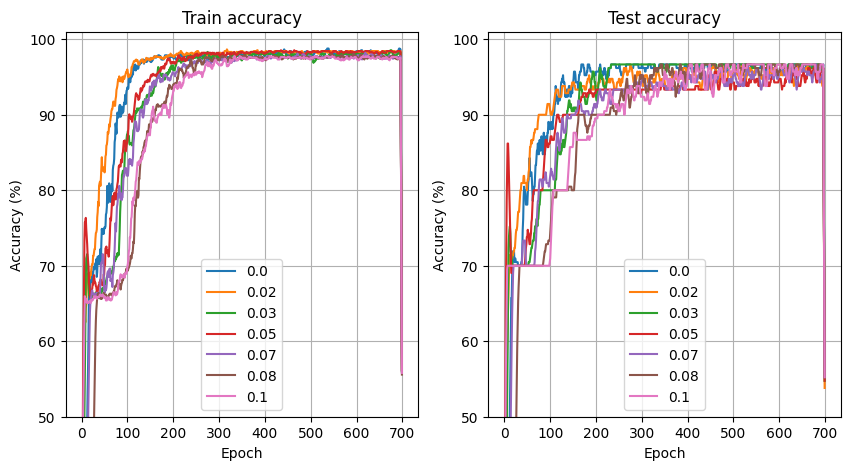

In [76]:
# plot some results
fig,ax = plt.subplots(1,2,figsize=(10,5))

ax[0].plot(train_results)
ax[0].set_title('Train accuracy')
ax[1].plot(test_results)
ax[1].set_title('Test accuracy')

# make the legend easier to read
leg_labels = [np.round(i,2) for i in l2_s]

# common features
for i in range(2):
  ax[i].legend(leg_labels)
  ax[i].set_xlabel('Epoch')
  ax[i].set_ylabel('Accuracy (%)')
  ax[i].set_ylim([50,101])
  ax[i].grid()

plt.show()

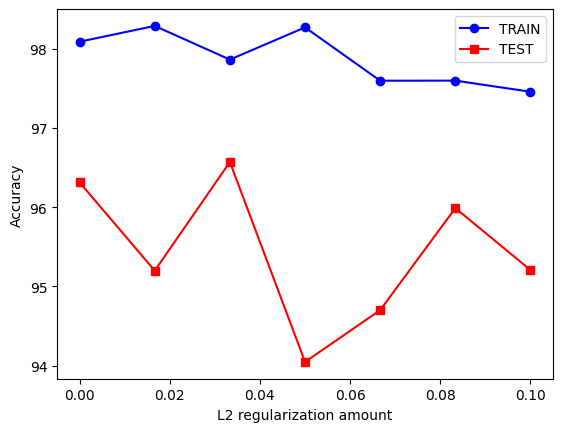

In [77]:
# average only some epochs
epoch_range = [300,650]


plt.plot(l2_s,
         np.mean(train_results[epoch_range[0]:epoch_range[1],:],axis=0),
         'bo-',label='TRAIN')

plt.plot(l2_s,
         np.mean(test_results[epoch_range[0]:epoch_range[1],:],axis=0),
         'rs-',label='TEST')

plt.xlabel('L2 regularization amount')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# L1 Regularization Practical Example with Iris Dataset

In [78]:
def create_l1_iris(learning_rate):

  model = nn.Sequential(
      nn.Linear(4, 32),
      nn.ReLU(),
      nn.Linear(32, 32),
      nn.ReLU(),
      nn.Linear(32, 3)
  )
  loss_fun = nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
  return model, loss_fun, optimizer

In [79]:
def train_l1_iris(model, loss_fun, optimizer, epochs, l1_lambda):
  train_acc = []
  test_acc = []
  num_weights = 0
  for p_name, weight in model.named_parameters():
    if 'bias' not in p_name:
      num_weights += weight.numel()

  for e in range(epochs):
    model.train()
    batch_acc = []
    for x, y in train_loader:
      y_hat = model(x)

      loss = loss_fun(y_hat, y)
      l1_term = torch.tensor(0.0, requires_grad=True)
      for p_name, weight in model.named_parameters():
        if 'bias' not in p_name:
          l1_term = l1_term + torch.sum(torch.abs(weight))

      loss = loss + (l1_lambda * l1_term / num_weights)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      batch_acc.append(100 * torch.mean((torch.argmax(y_hat, axis=1) == y).float()).item())
    train_acc.append(np.mean(batch_acc))

    model.eval()
    x, y = next(iter(test_loader))
    pred = model(x)
    test_acc.append(100 * torch.mean((torch.argmax(pred, axis=1) == y).float()).item())
  return train_acc, test_acc

## Test it once

In [80]:
# create a model
model_l1,loss_fun,optimizer = create_l1_iris(learning_rate=0.002)

# train the model
L1_lambda = 0.001
trainAcc,testAcc = train_l1_iris(model=model_l1, loss_fun=loss_fun, optimizer=optimizer, epochs=1, l1_lambda=0.01)

## Experimient

In [81]:
# range of L1 regularization amounts
L1_lambda = np.linspace(0,0.007,7)

epochs = 700

# initialize output results matrices
train_results = np.zeros((epochs,len(L1_lambda)))
test_results  = np.zeros((epochs,len(L1_lambda)))


for li in range(len(L1_lambda)):

  # create and train a model
  model_l1,loss_fun,optimizer = create_l1_iris(learning_rate=0.002)
  trainAcc,testAcc = train_l1_iris(model=model_l1, loss_fun=loss_fun, optimizer=optimizer, epochs=epochs, l1_lambda=li)
  # store data
  train_results[:,li] = smooth(trainAcc,10)
  test_results[:,li]  = smooth(testAcc,10)

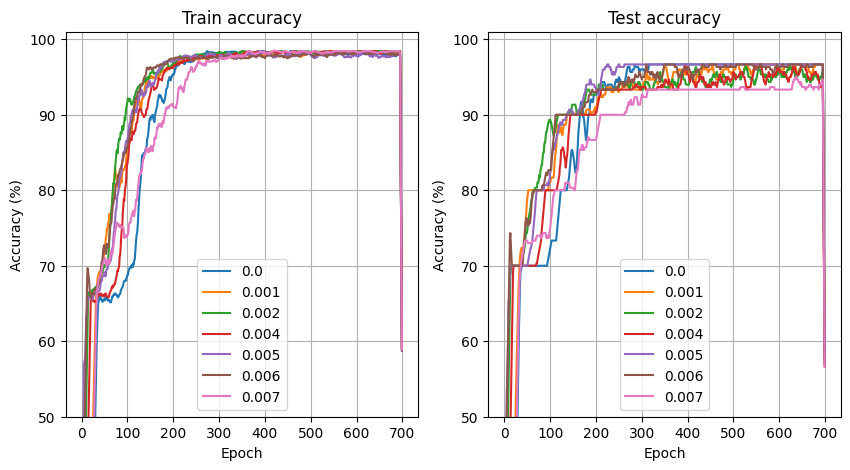

In [82]:
# plot some results
fig,ax = plt.subplots(1,2,figsize=(10,5))

ax[0].plot(train_results)
ax[0].set_title('Train accuracy')
ax[1].plot(test_results)
ax[1].set_title('Test accuracy')

# make the legend easier to read
leg_labels = [np.round(i,3) for i in L1_lambda]

# common features
for i in range(2):
  ax[i].legend(leg_labels)
  ax[i].set_xlabel('Epoch')
  ax[i].set_ylabel('Accuracy (%)')
  ax[i].set_ylim([50,101])
  ax[i].grid()

plt.show()

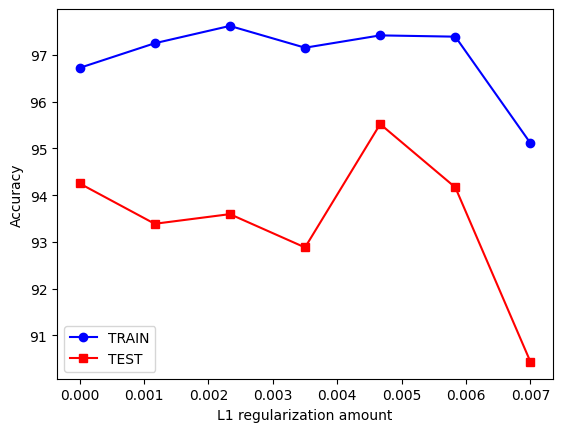

In [83]:
# average only some epochs
epoch_range = [150,400]


plt.plot(L1_lambda,
         np.mean(train_results[epoch_range[0]:epoch_range[1],:],axis=0),
         'bo-',label='TRAIN')

plt.plot(L1_lambda,
         np.mean(test_results[epoch_range[0]:epoch_range[1],:],axis=0),
         'rs-',label='TEST')

plt.xlabel('L1 regularization amount')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Mini-Batches

Instead of creating new models, I will use one of the models we already created (for example, using the dropout model with dropout = 0) as the batch sizes is handled before creating the train and test loader

In [94]:
batches = [2, 4, 8, 16, 32, 64]
epochs = 600
# initialize output results matrices
train_results = np.zeros((epochs,len(batches)))
test_results  = np.zeros((epochs,len(batches)))

test_loader = DataLoader(test_data, batch_size=test_data.tensors[0].shape[0])

for i in range(len(batches)):
  train_loader = DataLoader(train_data, batch_size=batches[i], shuffle=True, drop_last=True)
  # drop_last = true is used so that if the last batch is less than the batch size
  # it should be dropped, as this may affect the accuracy calculations in a biased way (both positive and negative)
  # as explained in the theortical notes

  # create and train a model
  model_batch,loss_fun,optimizer = create_drop_iris(dropout=0,learning_rate=0.001)
  trainAcc,testAcc = train_drop_iris(model=model_batch, loss_fun=loss_fun, optimizer=optimizer, epochs=epochs)
  # store data
  train_results[:,i] = smooth(trainAcc,10)
  test_results[:,i]  = smooth(testAcc,10)

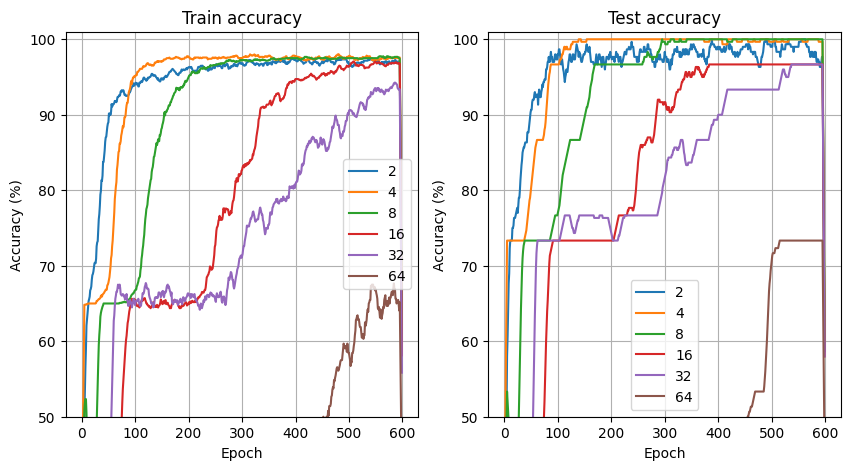

In [95]:
# plot some results
fig,ax = plt.subplots(1,2,figsize=(10,5))

ax[0].plot(train_results)
ax[0].set_title('Train accuracy')
ax[1].plot(test_results)
ax[1].set_title('Test accuracy')


# common features
for i in range(2):
  ax[i].legend(batches)
  ax[i].set_xlabel('Epoch')
  ax[i].set_ylabel('Accuracy (%)')
  ax[i].set_ylim([50,101])
  ax[i].grid()

plt.show()